In [21]:
import numpy as np
import matplotlib.pyplot as plt
import nrrd

from scipy.fft import fft2, ifft2, fftshift
import cupy as cp
import cupyx.scipy.ndimage as ndimage

from scipy.stats import pearsonr
from skimage.transform import rescale

from tqdm import trange

In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep

In [3]:
images, header = nrrd.read("20230307_121819round1_moving_sample.nrrd")

In [4]:
images.shape

(512, 512, 560)

In [5]:
volume_original = images[:,:,::4]

In [43]:
volume = rescale(volume_original, 8, channel_axis=2, order = 1)

In [44]:
# for i in range(0, volume.shape[-1]):
#     plt.figure(dpi=100)
#     plt.imshow(volume[:,:,i], vmin = 0, vmax = 300)
#     plt.colorbar()
#     plt.show()
#     # sleep(0.1)
#     clear_output(wait=True)

In [14]:
def cross_corr(image1, image2):

    # Compute the Fourier transforms of the images
    F1 = fft2(image1)
    F2 = fft2(image2)

    
    # Compute the cross-correlation in the frequency domain
    cross_correlation_freq = F1 * np.conj(F2)
    
    # Compute the inverse Fourier transform to get the cross-correlation in the spatial domain
    cross_correlation = ifft2(cross_correlation_freq)
    


    return np.real(cross_correlation)

In [15]:
i = 33
image1 = volume[:,:,i]

image2 = volume[:,:,i+1]

cross_correlation = cross_corr(image1, image2)

0.8734746457023858

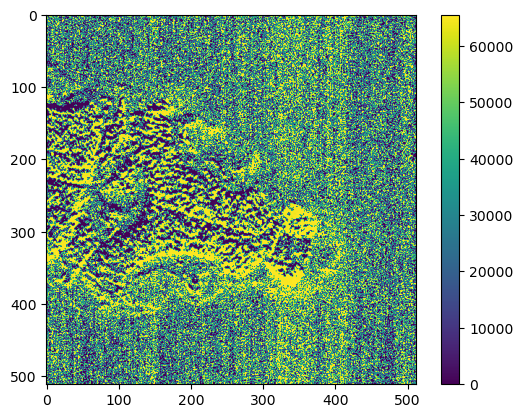

In [16]:
plt.imshow(image1 - image2)
plt.colorbar()


# Compute the Pearson correlation coefficient
correlation, _ = pearsonr(image1.flatten(), image2.flatten())
correlation

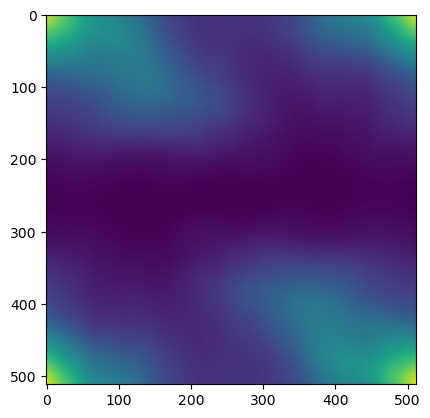

In [17]:
plt.imshow(cross_correlation)

In [18]:
tx, ty = np.where(cross_correlation == np.max(cross_correlation))
tx = tx[0]
ty = ty[0]

In [19]:
def translate_image(ref_image, tx, ty):

    w = ref_image.shape[0]
    h = ref_image.shape[1]

    
    A_t = np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1],
        
    ])

    A = A_t

    moving_image = ndimage.affine_transform(cp.array(ref_image), cp.array(A), output_shape = (ref_image.shape), mode='wrap')
    return moving_image.get()

In [258]:
moving_image = translate_image(image2, -tx, -ty)

0.92377614701869

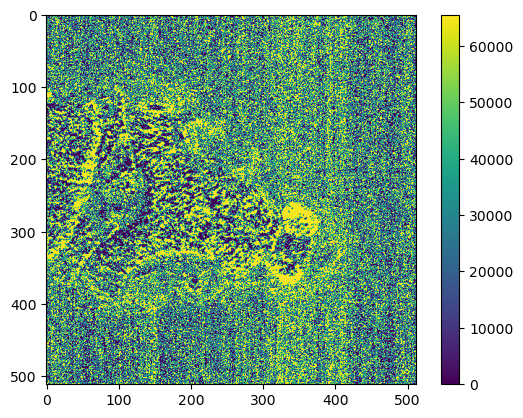

In [259]:
plt.imshow(image1 - moving_image)
plt.colorbar()

# Compute the Pearson correlation coefficient
correlation, _ = pearsonr(image1.flatten(), moving_image.flatten())
correlation

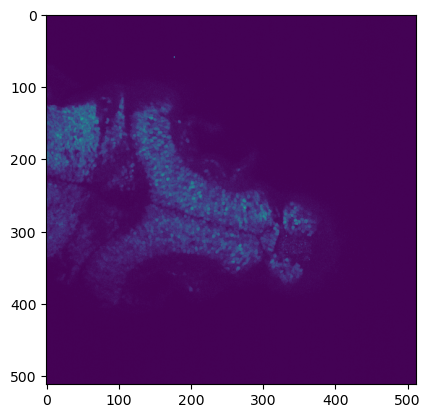

In [210]:
plt.imshow(moving_image)

In [22]:
volume_corrected = np.copy(volume)
max_corr = np.zeros(volume.shape[2]-1)
tx_all = np.zeros(volume.shape[2]-1)
ty_all = np.zeros(volume.shape[2]-1)
for i in trange(volume.shape[2]-1):
    
    image1 = volume_corrected[:,:,i]
    
    image2 = volume_corrected[:,:,i+1]


    
    
    cross_correlation = cross_corr(rescale(image1, 4), rescale(image2, 4))
    tx, ty = np.where(cross_correlation == np.max(cross_correlation))

    
    tx = tx[0]/4
    ty = ty[0]/4
    tx_all[i] = tx
    ty_all[i] = ty
    max_corr[i] = np.max(cross_correlation)
    

    moving_image = translate_image(image2, -tx, -ty)
    volume_corrected[:,:,i+1] = moving_image

100%|██████████| 139/139 [01:12<00:00,  1.93it/s]


In [27]:
volume_corrected.shape

(512, 512, 140)

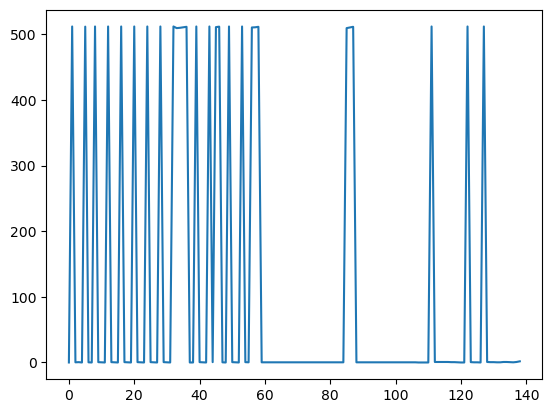

In [28]:
plt.plot(tx_all)

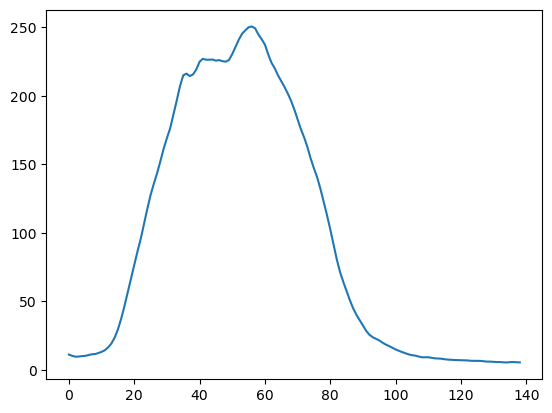

In [29]:
plt.plot(max_corr)

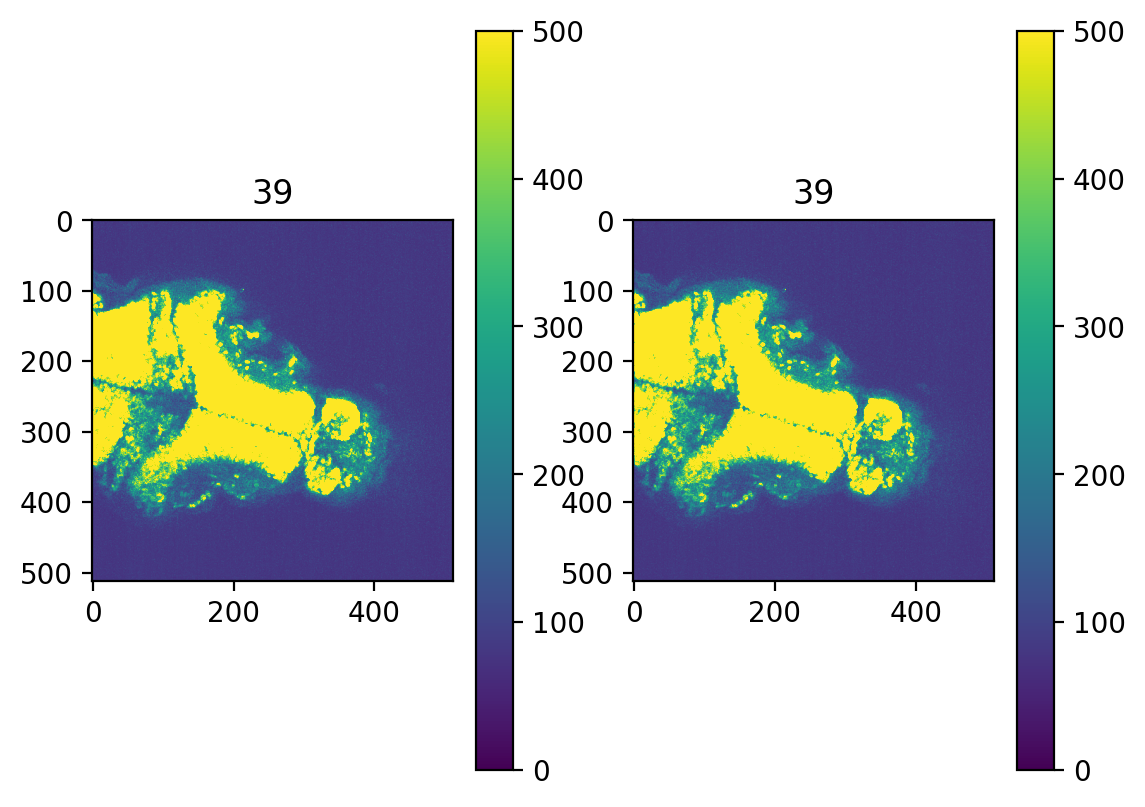

In [41]:
for i in range(30, 40):
    plt.figure(dpi=200)
    plt.subplot(1,2,1)
    plt.imshow(volume[:,:,i], vmin = 0, vmax = 500)
    plt.title(i)
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(volume_corrected[:,:,i], vmin = 0, vmax = 500)
    plt.title(i)
    plt.colorbar()

    
    plt.show()
    # sleep(0.1)
    clear_output(wait=True)

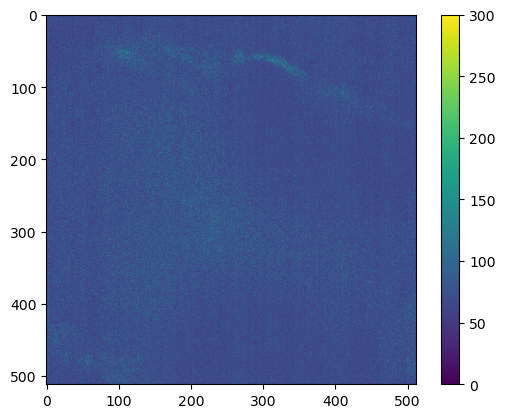

In [39]:
for i in range(0, volume.shape[-1]):
    plt.figure(dpi=100)
    plt.imshow(volume_corrected[:,:,i], vmin = 0, vmax = 300)
    plt.colorbar()
    plt.show()
    # sleep(0.1)
    clear_output(wait=True)